In [20]:
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parent.as_posix())

from matplotlib import pyplot as plt
import numpy as np
from numpy import typing as npt
from typing import NamedTuple
from utils.oscilloscope import Oscilloscope, plot_data
from utils.fitting import Sine
# from rberga06.phylab import Datum as d

In [21]:
class DataSet(NamedTuple):
    R: float
    L: float
    C: float
    Freq: npt.NDArray[np.float64]
    V: list[tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], int]]

class DataSetFit(NamedTuple):
    R: float
    L: float
    C: float
    Freq: npt.NDArray[np.float64]
    V: list[tuple[npt.NDArray[np.float64], Sine, Sine]]

In [8]:
def _fit_file(day: int, idx: int, freq: float, t: npt.NDArray[np.float64], ch1: npt.NDArray[np.float64], ch2: npt.NDArray[np.float64]) -> tuple[npt.NDArray[np.float64], Sine, Sine]:
    _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(t, ch1, color="C0")
    ax2.plot(t, ch2, color="C1")
    sine1 = Sine.fit(t, ch1, freq0=freq)
    sine2 = Sine.fit(t, ch2, freq0=sine1.freq)
    ax1.plot(t, sine1(t), color="C2")
    ax2.plot(t, sine2(t), color="C3")
    plt.savefig(f"elab/day{day}/{idx}fit.png")
    plt.close()
    return t, sine1, sine2


all_data_day1 = [(*Oscilloscope.Elettr.load_data(
    i, dir="data/day1", plot_dir="elab/day1",
    del_data_slices=(slice(-3, None),) if i in (0, 1, 3) else (),
), i) for i in range(51)]

In [31]:
dati: list[DataSet] = [DataSet(
    R = 1.e3,  # Ohm
    L = 1.0086e-3, # Henry
    C = 102.8e-9, # Farad
    Freq = np.array([
        np.nan, 1., 4.96, np.nan, np.nan, 10.2, 20.10, 50.13, 100.2, 200.0, 500.3, 1.004e3,
        np.nan, np.nan, 2.000e3, 5.000e3, 7.500e3, 10.000e3,
        15.e3, # forse qualitativo?
        20.02e3,
        # manca un 25.02 kHz
        30.01e3, 49.99e3, 99.99e3, 200.1e3, 499.9e3, 999.9e3, 5.001e6,
    ]),
    # "dFreq": np.array([.01, .01, .1, .01, .01, .1, .1, .3, .001e3]),
    V = all_data_day1[0:27],
),
# {
#     "R": 1.e3,
#     "Freq": np.array([]),
#     "V": all_data_day2[0:],
# }, {
#     "R": 1.e3,
#     "Freq": np.array([]),
#     "V": all_data_day2[0:0],
# }
#{
    # R = 100 Ohm
    # "Freq": np.array([1., ])
#}
]

dati_fit = [
    DataSetFit(
        R = ds.R, C = ds.C, L = ds.L,
        Freq = np.array([f for f in ds.Freq if not np.isnan(f)]),
        V = [_fit_file(1, idx, freq, t, ch1, ch2) for (freq, (t, ch1, ch2, idx)) in zip(ds.Freq, ds.V, strict=True) if not np.isnan(freq)]
    ) for ds in dati]

La frequenza di risonanza teorica è 15.630184064631386 kHz


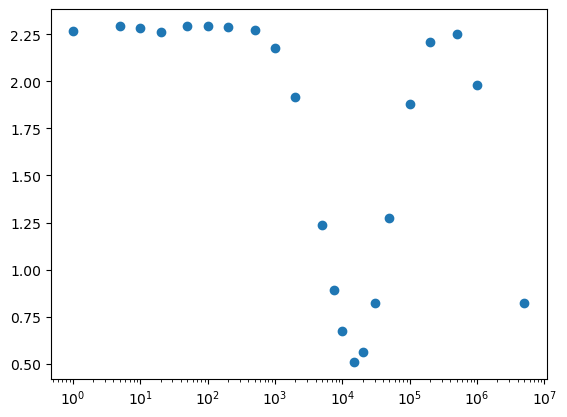

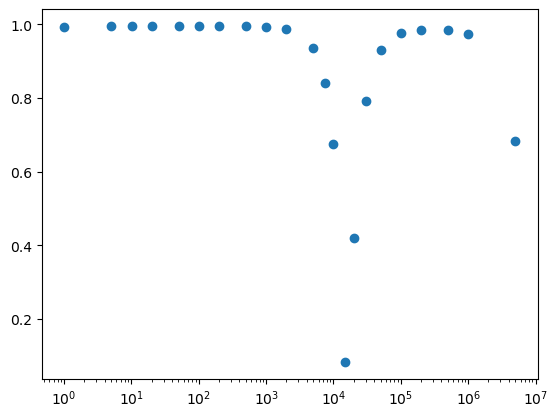

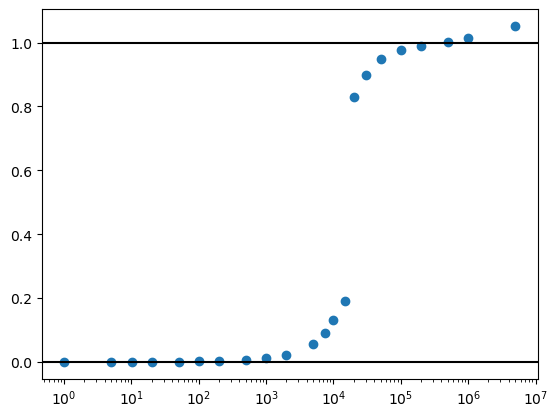

In [34]:
for set_di_dati in dati_fit:
    f_di_risonanza_teorica = 1 / (np.sqrt(set_di_dati.L * set_di_dati.C) * 2 * np.pi)
    print(f"La frequenza di risonanza teorica è {f_di_risonanza_teorica / 1_000} kHz")

    frequenze = []
    ampiezze_ch1 = []
    ampiezze_ch2 = []
    sfasamenti = []
    ch1: Sine
    ch2: Sine
    for f, (t, ch1, ch2) in zip(set_di_dati.Freq, set_di_dati.V, strict=True):
        ampiezze_ch1.append(ch1.ampl)
        ampiezze_ch2.append(ch2.ampl)
        frequenze.append(ch1.freq)
        fase = (ch1.phase - ch2.phase) / (2 * np.pi)
        # while fase > .5: fase -= 1
        # while fase < -.5: fase += 1
        if f > f_di_risonanza_teorica:
            fase += 1
        sfasamenti.append(fase)
    ampiezze_ch1 = np.array(ampiezze_ch1)
    ampiezze_ch2 = np.array(ampiezze_ch2)

    plt.scatter(frequenze, ampiezze_ch1)
    plt.xscale("log")
    plt.show()
    plt.scatter(frequenze, ampiezze_ch2 / ampiezze_ch1)
    plt.xscale("log")
    plt.show()
    plt.scatter(frequenze, sfasamenti)
    plt.xscale("log")
    plt.hlines([0.0, 1.0], *plt.xlim(), color="k")
    # plt.ylim((-0.5, 0.5))
    plt.show()